# <span style="color:red">Solutions to Homework 3<span>

## Financial Analytics

### UChicago ADSP

#### Spring 2024
* Mark Hendricks
* hendricks@uchicago.edu

# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (A): US Treasuries in November 2008

## Data
* Use the data file `treasury_ts_2015-08-15.xlsx`.
* Examine the treasure issues with `kytreasno` of `204046` and `204047`. These are the bond and note (respectively) which mature on 2015-08-15.
* Look at the data on 2008-11-04.

### 1.1. The situation

Make a chart comparing the bonds on the following features, (as of Nov 4, 2008.)
* coupon rate
* bid
* ask
* accrued interest
* dirty price
* duration (quoted in years, not days, assuming 365.25 days per year.)
* modified duration
* YTM

### 1.2. Hedge Ratio

Suppose you are building a trade to go long $n_i$ bonds (`204046`) and short $n_j$ notes (`204047`).

We can find an equation for $n_j$ in terms of $n_i$ such that the total holdings will have duration equal to zero. (Having zero duration also means have zero dollar duration, if helpful.)

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

Suppose you will 
* use \\$1mm of your own capital (equity)
* use \\$49mm of borrowed capital (debt)
* to buy \\$50mm of the bond issue (`204046`).

Use the hedge ratio above to short a number of notes (`204047`) to keep zero duration.

Report the number of bonds and notes of your position, along with the total dollars in the short position.

#### Note
The leverage in the position would be obtained using repo.
* Buy 50mm of bonds
* Simultaneously repo them, meaning sell them to a counterparty for 49mm
* Contract to repurchase them for 49mm plus interest at a future date
* Net expenditure right now is 1mm, with 49mm borrowed.

### 1.3. Profit Opportunity

Using the concept of **modified duration**, how much profit or loss (PnL) would you expect to make for every basis point of convergence in the spread? Specifically, assume the convergence is symmetric: the bond's (`204046`) ytm goes down 0.5bp and the note (`204047`) ytm goes up 0.5bp.

Describe the PnL you would expect to achieve on your position should this happen. Specify the PnL of the long position, the short position, and the net total.

Suppose the spread in YTM between the two securities disappears, due to a symmetric move of roughly ~17bps in each security's YTM. What is the PnL? (This is just a linearly scaling of your prior answer for a 1bp convergence.) 

### 1.4. Result in 2008

Calculate the profit (or loss) on the position on the following two dates:
* 2008-11-25
* 2008-12-16

To calculate the pnl on each date, simply use the prices of the securities on those dates along with your position sizes, ($n_i, n_j$). No coupon is being paid in November or December, so all you need is the "dirty" price on these two dates.

Does the pnl make sense (approximately) given your results in 1.3 with regard to the sensitivity of pnl to moves in the YTM spread?

### 1.5. Examining the Trade through June 2009

Calculate the pnl of the trade for the following dates:
* 2009-01-27
* 2009-03-24
* 2009-06-16

Did the trade do well or poorly in the first six months of 2009?

Calculate the YTM spreads on these dates. Does the YTM spread correspond to pnl roughly as we would expect based on the calculation in 1.3?

***

# <span style="color:red">Solution 1</span>

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *
from tradebondpair import *

In [2]:
filepath_tsdata = f'../data/treasury_ts_2015-08-15.xlsx'
info = pd.read_excel(filepath_tsdata,sheet_name='info',index_col=0)
tsdata = pd.read_excel(filepath_tsdata,sheet_name='database')
tsdata.columns = tsdata.columns.str.upper()

### <span style="color:red">1.1.</span>

In [3]:
DATE0 = '2008-11-04'
tab = get_table(info,tsdata,DATE0)
tab

kytreasno,204046,204047
issue date,1985-08-15 00:00:00,2005-08-15 00:00:00
maturity date,2015-08-15 00:00:00,2015-08-15 00:00:00
coupon rate,10.625,4.25
type,bond,note
bid,141.859375,105.953125
ask,141.890625,105.984375
accrued interest,2.338655,0.935462
clean price,141.875,105.96875
dirty price,144.213655,106.904212
duration,5.230138,5.935706


#### Long and Short ID

We long the bond with the higher YTM.

We short the bond with the lower YTM.

In [4]:
keyLong = tab.loc['ytm'].astype('float64').idxmax()
keyShort = tab.loc['ytm'].astype('float64').idxmin()

### <span style="color:red">1.2.</span>

In [5]:
financing = pd.DataFrame(dtype='float64',index=['long','short'])
financing['haircut'] = [.02,.02]
financing['repo'] = [.0015,.0010]
financing

,haircut,repo
long,0.02,0.0015
short,0.02,0.0010


In [6]:
LONGEQUITY = 1e6

balsheet, fmt = trade_balance_sheet(prices=tab.loc['dirty price'], durations=tab.loc['duration'], haircuts=financing['haircut'], long_equity=LONGEQUITY, key_long=keyLong, key_short=keyShort)
balsheet.style.format(fmt,na_rep='')

,equity,assets,contracts
204046,"$1,000,000.00","$50,000,000.00","346,707.81"
204047,"$-881,131.58","$-44,056,578.93","-412,112.66"


### <span style="color:red">1.3.</span>

#### The Current Situation

Spread had widened enormously, no trade, then contracted.

But now it has spread out once again to nearly 35bps.

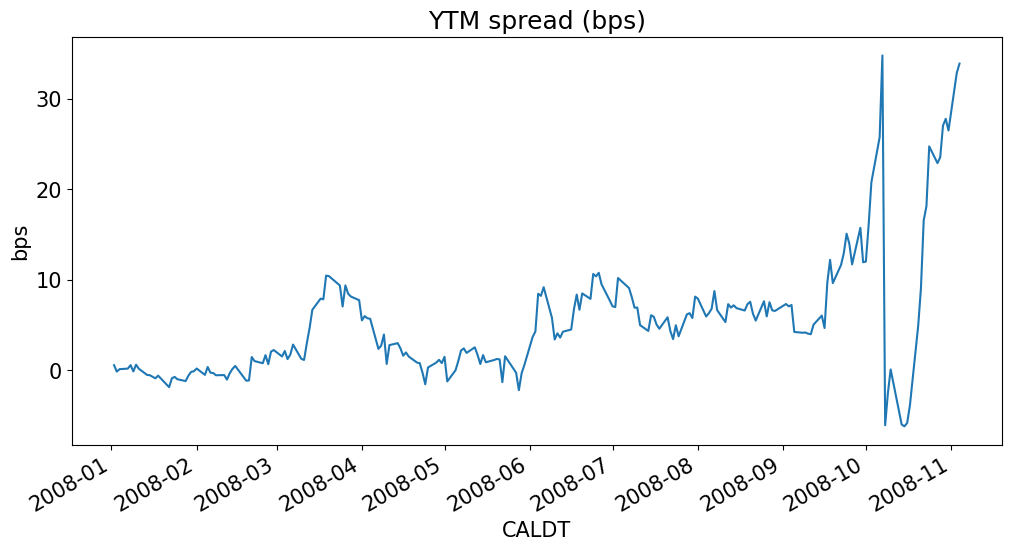

In [7]:
spread = get_spread_bps(tsdata)
spread = spread[keyShort]
spread.rename('ytm spread (bps)',inplace=True)
spread.loc['2008':'2008-11-04'].plot(ylabel='bps',title='YTM spread (bps)');

#### Scenario: Spread disappears, as ytm converge to midpoint

In [8]:
spread_convergence = tab.loc['ytm'].diff().dropna().abs().values[0]

pnl_spread_converges, fmt_dict = pnl_spread_trade(spread_convergence,tab.loc['modified duration'], tab.loc['dirty price'], balsheet['contracts'])
pnl_spread_converges.style.format(fmt_dict,na_rep='')

,ytm change,modified duration,price,contracts,pnl
kytreasno,,,,,
204046,-0.1695%,5.14,$144.21,"346,707.81","$435,509.58"
204047,0.1695%,5.84,$106.90,"-412,112.66","$436,236.08"
total,,,,,"$871,745.67"


#### Scenario: 1bp narrowing of spread, as ytm of each moves half that much

In [9]:
spread_convergence = .0001

pnl_spread_1bp, fmt_dict = pnl_spread_trade(spread_convergence,tab.loc['modified duration'], tab.loc['dirty price'], balsheet['contracts'])
pnl_spread_1bp.style.format(fmt_dict,na_rep='')

,ytm change,modified duration,price,contracts,pnl
kytreasno,,,,,
204046,-0.0050%,5.14,$144.21,"346,707.81","$12,845.71"
204047,0.0050%,5.84,$106.90,"-412,112.66","$12,867.14"
total,,,,,"$25,712.85"


In [10]:
opportunity = pd.DataFrame([pnl_spread_converges.loc['total','pnl'], pnl_spread_1bp.loc['total','pnl']], columns=['pnl'],index=['converges','1bp'])
opportunity['return'] = opportunity['pnl'] / balsheet['equity'].abs().sum()
opportunity.style.format({'return':'{:.2%}','pnl':'${:,.2f}'})

,pnl,return
converges,"$871,745.67",46.34%
1bp,"$25,712.85",1.37%


### <span style="color:red">1.4.</span>

In [11]:
ask = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK')
bid = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDBID')
accint = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDACCINT')
dirty = (ask + bid)/2 + accint
dirty = dirty[[keyLong,keyShort]]

duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN')[[keyLong,keyShort]] / 365.25

In [12]:
n_weeks = 9
trade, fmt_dict = trade_evolution(DATE0, tab.loc['maturity date',keyShort], n_weeks, balsheet, dirty, duration, financing, tab.loc['coupon rate'], keyLong, keyShort)

summary = trade[['price change','coupons','total pnl']].join(spread,how='left')

fmt = fmt_dict
fmt['ytm spread (bps)'] = '{:.2f}'
summary.style.format(fmt,na_rep='')

,price change,coupons,total pnl,ytm spread (bps)
2008-11-04 00:00:00,$0.00,$0.00,$0.00,33.88
2008-11-10 00:00:00,"$-115,883.84",$0.00,"$-115,883.84",38.54
2008-11-18 00:00:00,"$-181,887.02",$0.00,"$-181,887.02",41.15
2008-11-25 00:00:00,"$-499,072.82",$0.00,"$-499,072.82",52.96
2008-12-02 00:00:00,"$-748,066.35",$0.00,"$-748,066.35",61.46
2008-12-09 00:00:00,"$-903,774.22",$0.00,"$-903,774.22",67.29
2008-12-16 00:00:00,"$-1,049,332.75",$0.00,"$-1,049,332.75",71.61
2008-12-23 00:00:00,"$-805,707.20",$0.00,"$-805,707.20",63.50
2008-12-30 00:00:00,"$-756,986.09",$0.00,"$-756,986.09",61.81


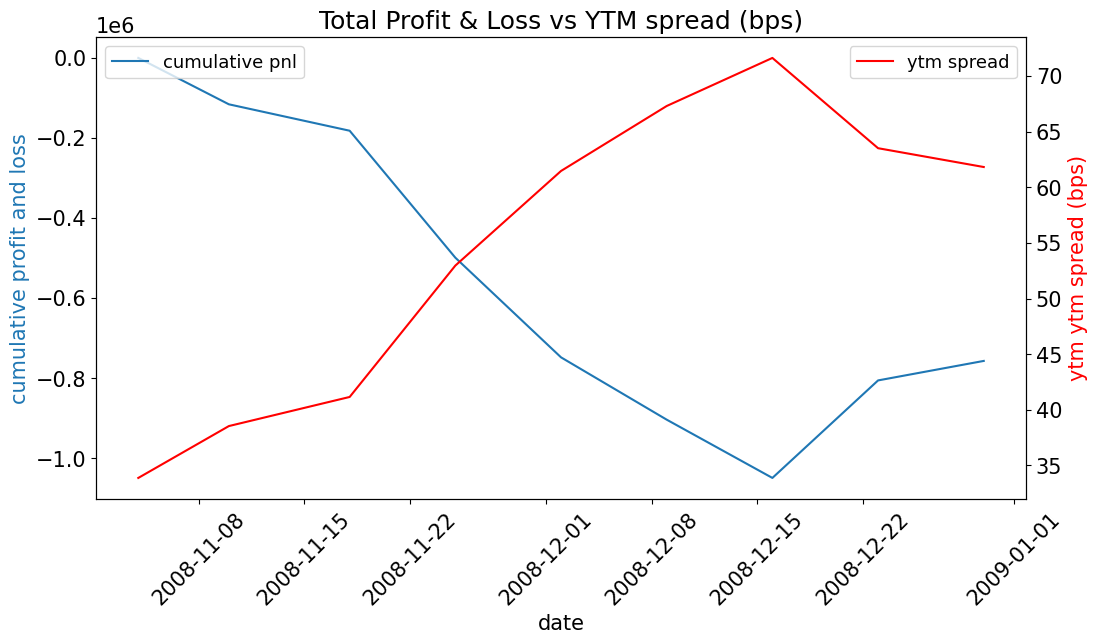

In [13]:
fig, ax = plt.subplots()

ax.plot(summary[['total pnl']])
ax.set_xlabel('date');
ax.set_ylabel('cumulative profit and loss',color=ax.get_lines()[-1].get_color());
ax.tick_params(axis='x', rotation=45)
ax.legend(['cumulative pnl'],loc=2)

ax2 = ax.twinx()
ax2.plot(summary[['ytm spread (bps)']], color='r')
ax2.set_ylabel('ytm ytm spread (bps)',color=ax2.get_lines()[-1].get_color());
ax2.legend(['ytm spread'],loc=1)

ax.set_title('Total Profit & Loss vs YTM spread (bps)');

#### Conclusion:

Loses a ton! Loss is roughly what we expected to gain.
* Spread diverges ~35bps instead of converging ~35bps.
* So our estimated pnl response (via modified duration) to ytm spread is reasonable approximation.

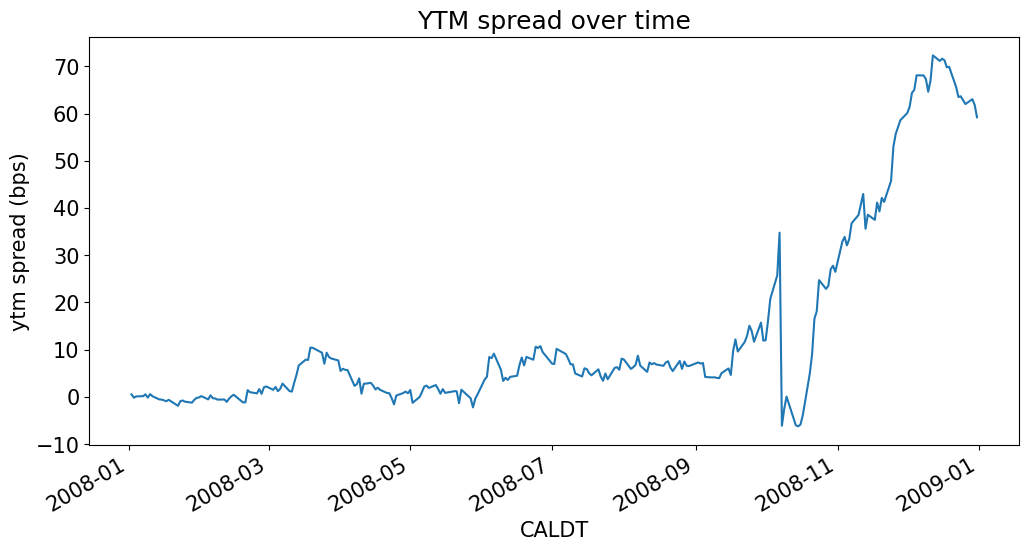

In [14]:
spread.loc['2008'].plot(ylabel='ytm spread (bps)',title='YTM spread over time');

#### Longer View

In [15]:
n_weeks = 35
trade_long, fmt_dict = trade_evolution(DATE0, tab.loc['maturity date',keyShort], n_weeks, balsheet, dirty, duration, financing, tab.loc['coupon rate'], keyLong, keyShort)

summary_long = trade_long[['price change','coupons','total pnl']].join(spread,how='left')

fmt = fmt_dict
fmt['ytm spread (bps)'] = '{:.2f}'
summary_long.iloc[::4,:].style.format(fmt,na_rep='')

,price change,coupons,total pnl,ytm spread (bps)
2008-11-04 00:00:00,$0.00,$0.00,$0.00,33.88
2008-12-02 00:00:00,"$-748,066.35",$0.00,"$-748,066.35",61.46
2008-12-30 00:00:00,"$-756,986.09",$0.00,"$-756,986.09",61.81
2009-01-27 00:00:00,"$20,657.36",$0.00,"$20,657.36",35.33
2009-02-24 00:00:00,"$-561,855.73","$966,145.83","$404,290.09",22.07
2009-03-24 00:00:00,"$-545,508.23","$966,145.83","$420,637.60",22.02
2009-04-21 00:00:00,"$-222,863.63","$966,145.83","$743,282.19",10.41
2009-05-19 00:00:00,"$22,192.58","$966,145.83","$988,338.41",1.32
2009-06-16 00:00:00,"$234,164.91","$966,145.83","$1,200,310.74",-7.14


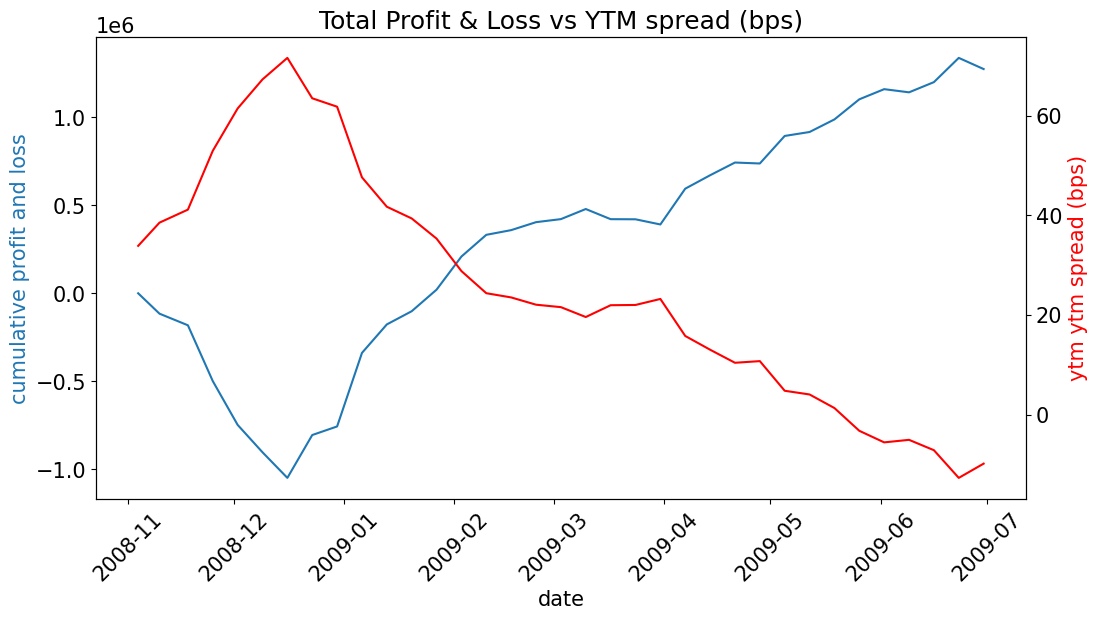

In [16]:
fig, ax = plt.subplots()

ax.plot(summary_long[['total pnl']])
ax.set_xlabel('date');
ax.set_ylabel('cumulative profit and loss',color=ax.get_lines()[-1].get_color());
ax.tick_params(axis='x', rotation=45)

ax2 = ax.twinx()
ax2.plot(summary_long[['ytm spread (bps)']], color='r')
ax2.set_ylabel('ytm ytm spread (bps)',color=ax2.get_lines()[-1].get_color());

ax.set_title('Total Profit & Loss vs YTM spread (bps)');

#### It converges!

The trade pays off approximately as expected.
* Actually, a little better given spread goes negative and some nonlinearity in the relationship.

## Not Submitted: To Discuss in Class

#### Was this convergence expected or lucky?

Expected. 
* Look at the history of the ytm spread of these two instruments from 2005 (issuance of the note) through 2014.
* Leave out 2015, as the spread may diverge as the instruments approach maturity.

Figure and table below.

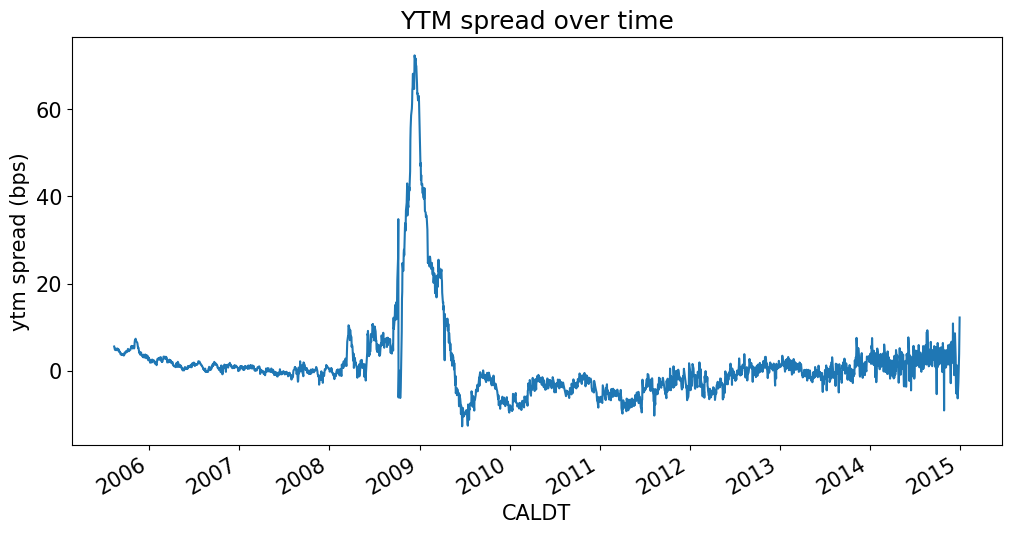

In [17]:
spread.loc['2005':'2014'].plot(ylabel='ytm spread (bps)',title='YTM spread over time');

In [18]:
spread.loc[:'2014'].describe().to_frame()

,ytm spread (bps)
count,2349.000000
mean,1.399500
std,9.735221
min,-12.694467
25%,-2.625583
50%,0.108490
75%,1.979015
max,72.309578


Note:
* On average, only 1.4bps apart!
* Being 2bps apart is a 75th percentile occurence.
* Max divergence (~72bps) is this episode.

So the logic of the trade was reasonable: it was an aberrant spread, and it was expected to converge.

But given it first diverged, it could have led to such large losses as to force exit by the traders.

***

# 2 Bond Metrics

Use the data in `data/select_maturities_2023-08-31.xlsx`.

It gives treasury bond data for various maturities, spaced roughly six months apart.

Feel free to approximate the time-to-maturity to be exactly semiannually if that is easier for the problem below.

### 2.1.

Write a function to calculate the yield-to-maturity for each issue.

You will need to use a nonlinear solver to solve for the YTM.

#### Hint 
Consider using `fsolve` to solve the yield implicitly from the nonlinear equation. To that point, try

`from scipy.optimize import fsolve`


### 2.2.
Plot the time-to-maturity against the calculated YTM.

### 2.3.
Calculate the duration and modified duration of each bond.

### 2.4 Optional

For the Treasury bills, calculate the **discount yields**.

Identify the T-bills using `instrument`=4 or looking for `cpn rate` of 0.

***

# <span style="color:red">Solution 2</span>

## <span style="color:red">2.1</span>

In [19]:
filepath = '../data/select_maturities_2023-08-31.xlsx'
quotes = pd.read_excel(filepath).set_index('kytreasno')
quotes['price'] = (quotes['bid'] + quotes['ask'])/2 + quotes['accrint']
quotes

,date,issue date,maturity date,ttm,bid,ask,accrint,ytm,duration,outstanding,cpn rate,instrument,price
kytreasno,,,,,,,,,,,,,
208097,2023-08-31,2023-08-31,2024-02-29,0.498289,97.333194,97.338250,0.000000,0.000148,182.000000,66723,0.000,4,97.335722
207928,2023-08-31,2022-08-31,2024-08-31,1.002053,97.929688,97.945312,0.000000,0.000145,363.026814,49726,3.250,2,97.937500
208013,2023-08-31,2023-02-28,2025-02-28,1.497604,99.281250,99.296875,0.000000,0.000139,534.703977,51530,4.625,2,99.289062
208101,2023-08-31,2023-08-31,2025-08-31,2.001369,100.234375,100.269531,0.000000,0.000132,704.689328,49666,5.000,2,100.251953
207676,2023-08-31,2021-02-28,2026-02-28,2.496920,90.265625,90.296875,0.000000,0.000126,907.180690,74214,0.500,2,90.281250
207759,2023-08-31,2021-08-31,2026-08-31,3.000684,89.500000,89.523438,0.000000,0.000123,1085.093032,68664,0.750,2,89.511719
207845,2023-08-31,2022-02-28,2027-02-28,3.496235,91.695312,91.718750,0.000000,0.000121,1240.082921,62080,1.875,2,91.707031
207930,2023-08-31,2022-08-31,2027-08-31,4.000000,95.390625,95.414062,0.000000,0.000119,1382.439796,50858,3.125,2,95.402344
208015,2023-08-31,2023-02-28,2028-02-29,4.498289,98.710938,98.718750,0.000000,0.000117,1518.888512,52769,4.000,2,98.714844


### Note

The accrued interest provided in this CRSP file is reported incorrectly. That is fine, but it is a reason our calculations will not match the provided ytm column.

In [20]:
from scipy.optimize import fsolve

In [21]:
def price_bond(ytm, T, cpn, cpnfreq=2, face=100, accr_frac=None):
    ytm_n = ytm/cpnfreq
    cpn_n = cpn/cpnfreq
    
    if accr_frac is None:
        #accr_frac = (T-round(T))*cpnfreq
        accr_frac = 0
    
    N = T * cpnfreq
    price = face * ((cpn_n / ytm_n) * (1-(1+ytm_n)**(-N)) + (1+ytm_n)**(-N)) * (1+ytm_n)**(accr_frac)
    return price

In [22]:
def ytm(price, T, cpn, cpnfreq=2, face=100, accr_frac=None):
    pv_wrapper = lambda y: price - price_bond(y, T, cpn, cpnfreq=cpnfreq, face=face, accr_frac=accr_frac)
    ytm = fsolve(pv_wrapper,.01)
    return ytm

In [23]:
for i in quotes.index:
    quotes.loc[i,'ytm calculated'] = ytm(quotes.loc[i,'price'],quotes.loc[i,'ttm'],quotes.loc[i,'cpn rate']/100)

quotes[['ytm provided']] = quotes[['ytm']] * 365
quotes[['ytm provided','ytm calculated']]

,ytm provided,ytm calculated
kytreasno,,
208097,0.054157,0.054935
207928,0.053105,0.053920
208013,0.050633,0.051242
208101,0.048017,0.048664
207676,0.046126,0.046688
207759,0.044738,0.045275
207845,0.044131,0.044632
207930,0.043405,0.043908
208015,0.042701,0.043174


## <span style="color:red">2.2</span>

<Axes: xlabel='ttm', ylabel='ytm calculated'>

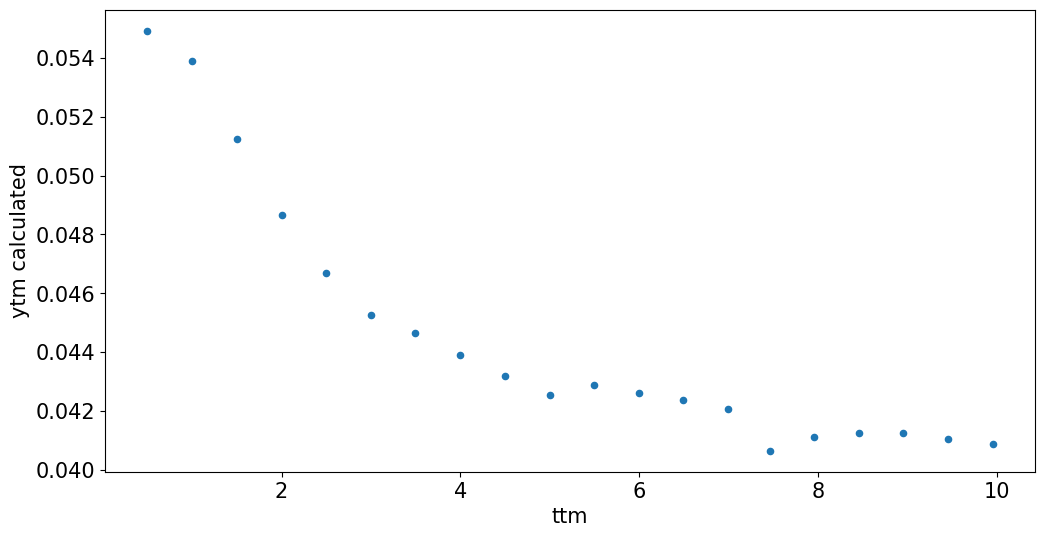

In [24]:
quotes[['ttm','ytm calculated']].plot.scatter('ttm','ytm calculated')
#quotes[['ttm','ytm provided']].plot.scatter('ttm','ytm provided')

## <span style="color:red">2.3</span>

In [25]:
def duration_closed_formula(tau, ytm, cpnrate=None, freq=2):

    if cpnrate is None:
        cpnrate = ytm
        
    y = ytm/freq
    c = cpnrate/freq
    T = tau * freq
        
    if cpnrate==ytm:
        duration = (1+y)/y  * (1 - 1/(1+y)**T)
        
    else:
        duration = (1+y)/y - (1+y+T*(c-y)) / (c*((1+y)**T-1)+y)

    duration /= freq
    
    return duration

In [26]:
for i in quotes.index:
    quotes.loc[i,'duration calculated'] = duration_closed_formula(quotes.loc[i,'ttm'],quotes.loc[i,'ytm calculated'], cpnrate=quotes.loc[i,'cpn rate']/100)

quotes['duration given'] = quotes['duration']/365.25

In [27]:
quotes[['duration given','duration calculated']]

,duration given,duration calculated
kytreasno,,
208097,0.498289,0.498289
207928,0.993913,0.993926
208013,1.463940,1.463958
208101,1.929334,1.929371
207676,2.483725,2.483731
207759,2.970823,2.970837
207845,3.395162,3.395207
207930,3.784914,3.785019
208015,4.158490,4.158630


## <span style="color:red">2.4</span>

In [28]:
def discount_yield(price,ttm,face=100):
    dtm = ttm*365.25
    return (360/dtm)*(face-price)/face

In [29]:
idx = quotes['instrument']==4
ylds_comp = discount_yield(quotes[idx]['price'], quotes[idx]['ttm']).to_frame()
ylds_comp.columns = ['discount yield']
ylds_comp['ytm'] = quotes[idx]['ytm calculated']
ylds_comp.style.format('{:.2%}')

,discount yield,ytm
kytreasno,,
208097,5.27%,5.49%
